# ALeRCE: Classic Machine Learning vs Deep Learning

Authors: Guillermo Cabrera-Vives, Javier Arredondo, Ignacio Reyes

Partially based on: 
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ML_Light_Curve_Classifier.ipynb

## Table of contents:
* [Required libraries](#Required-libraries)
* [The classifier](#The-classifier)
    * [Brief explanation of the data](#Brief-explanation-of-the-data)
    * [Model description](#Model-description)
    * [Results](#Results)
    * [ALeRCE Explorer](#ALeRCE-Explorer)
* [Query model predictions](#Query-model-predictions)
    * [Which objects have we found?](#Which-objects-have-we-found?)
* [Spatial distribution of the predictions](#Spatial-distribution-of-the-predictions)
    * [Galactic sources](#Galactic-sources-(LPV,-CEP,-YSO))
    * [Extragalactic sources](#Extragalactic-sources-(QSO,-AGN,-Blazar,-SNe))
* [Visualizing a sample of predicted objects](#Visualizing-a-sample-of-predicted-objects)

## Required libraries

In [1]:
#!pip install alerce

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alerce.core import Alerce
import psycopg2
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

run_all = True

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Accessing ALeRCE Data

ALeRCE's database contains all the alerts generated by the Zwicky Transient Facility (ZTF) public stream. An alert is generated by ZTF each time an area of the sky is observed and a difference in brightness is detected. All alerts from the same coordinates are grouped into the same object with an object id (oid). Up to this date, the database contains more than 100 million alerts and 35 million objects.

Most ZTF detections come from two filters, g and r. Let's see an example of a light curve from ZTF.

In [3]:
alerce_client = Alerce()

In [4]:
def colormap(i):
    if i == 1:
        return '#56e03a'
    elif i == 2:
        return '#d42f4b'
    else:
        return '#000000'

def plot_light_curve(df, title='', period=None, apparent = False):
    for fid in df.fid.unique():
        fid_df = df[df.fid == fid]
        if len(fid_df) == 0:
            continue
        if apparent == True:
            mag = fid_df.magpsf_corr
            err = fid_df.sigmapsf_corr_ext
        else:
            mag = fid_df.magpsf
            err = fid_df.sigmapsf
        if period is not None:
            mjd = (fid_df.mjd % period) / period
            mjd = pd.concat((mjd, mjd+1))
            mag = pd.concat((mag, mag))
            err = pd.concat((err, err))
            print (mjd.shape, mag.shape, err.shape)
        else:
            mjd = fid_df.mjd
        plt.errorbar(mjd, mag, yerr=err,
            fmt='*', c=colormap(fid))
    plt.gca().invert_yaxis()
    if period is not None:
        plt.xlabel(f'Phase (period={period:.3f})')
    else:
        plt.xlabel('Date [mjd]')
    plt.ylabel('Apparent magnitude [mag]')
    plt.title(title)

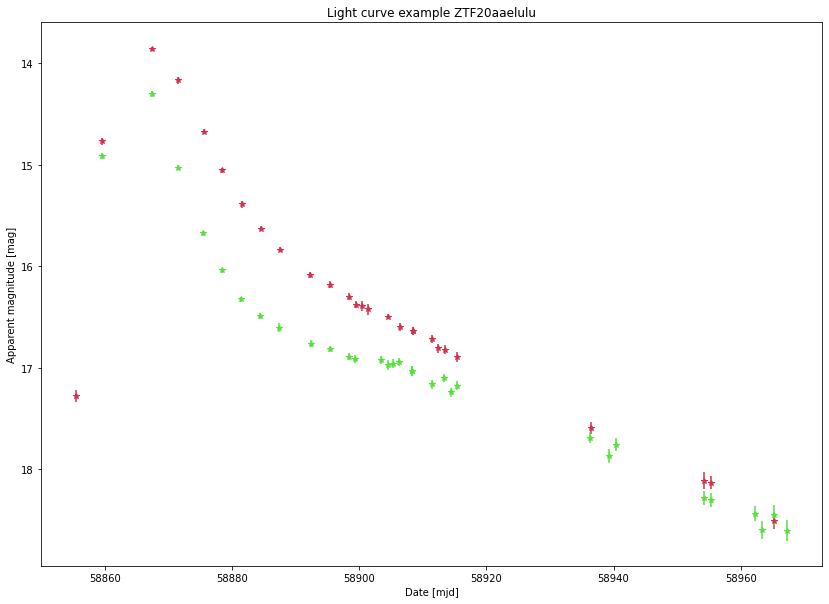

In [5]:
fig = plt.figure(figsize=(14, 10))
fig.patch.set_facecolor('white')
oid = 'ZTF20aaelulu'
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}')

### Query the ALeRCE DB for features

The ALeRCE database (ADB) contains  over 170 features calculated for each object. We will directly query the ADB and get those features out. We start by downloading the credentials file and connecting to the ADB.

In [6]:
!wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
credentials_file = "alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

--2022-07-25 19:17:58--  https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json [following]
--2022-07-25 19:17:59--  https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: ‘alercereaduser_v4.json.3’

alercereaduser_v4.j 100%[===================>]     156  --.-KB/s    in 0s      

2022-07-25 19:17:59 (2.25 MB/s) - ‘alercereaduser_v4.json.3’ saved [156/156]

As an example, we will use the object with object id (oid) 'ZTF19acelhxy'.

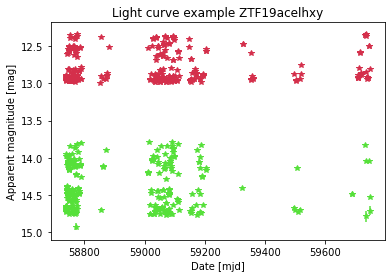

In [7]:
oid = "ZTF19acelhxy"
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}', apparent = True)

Query the ADB for all the features for that particular object

In [8]:
query = "select * from feature where oid='" + str(oid) + "';"
object_feat = pd.read_sql_query(query, conn)

In [9]:
object_feat


,oid,name,value,fid,version
0,ZTF19acelhxy,iqr,0.591698,1,lc_classifier_1.2.1-P
1,ZTF19acelhxy,iqr,0.349977,2,lc_classifier_1.2.1-P
2,ZTF19acelhxy,Amplitude,0.465350,1,lc_classifier_1.2.1-P
3,ZTF19acelhxy,AndersonDarling,1.000000,1,lc_classifier_1.2.1-P
4,ZTF19acelhxy,Autocor_length,1.000000,1,lc_classifier_1.2.1-P
...,...,...,...,...,...
173,ZTF19acelhxy,max_diffmaglim_after_fid,21.116800,1,lc_classifier_1.2.1-P
174,ZTF19acelhxy,max_diffmaglim_after_fid,20.914000,2,lc_classifier_1.2.1-P
175,ZTF19acelhxy,median_diffmaglim_after_fid,20.321150,2,lc_classifier_1.2.1-P
176,ZTF19acelhxy,SPM_A,6.454099,1,lc_classifier_1.2.1-P


In [10]:
period = object_feat[object_feat['name'] == "Multiband_period"]['value'].values[0]

In [11]:
period

3.799999864101415

Now, we fold and plot the light curve.

(546,) (546,) (546,)
(504,) (504,) (504,)


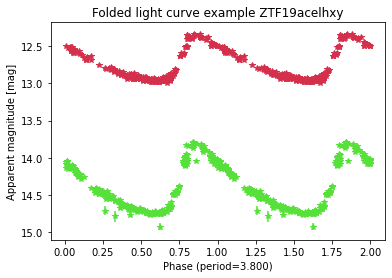

In [12]:
plot_light_curve(light_curve, title=f'Folded light curve example {oid}', period = period, apparent = True)

In the ALeRCE explorer: https://alerce.online/object/ZTF19acelhxy

## Training set

We will use the ALeRCE taxonomy and the ZTF labeled dataset described in Sánchez-Sáez et.al. 2021, AJ, 161, 141.

In [13]:
df_labels = pd.read_csv ("data/labeled_set_lc_classifier_SanchezSaez_2020.csv")

In [14]:
df_labels.head()

,oid,classALeRCE,ra,dec,source,id_source
0,ZTF19aapcxhy,AGN,154.202129,18.723076,Oh2015,5.877420127343739e+17
1,ZTF18abtmwvo,AGN,46.074050,0.474212,Oh2015,5.880155098263717e+17
2,ZTF18acvgdfy,AGN,134.407409,5.472596,Oh2015,5.877327033915148e+17
3,ZTF19aabvjsi,AGN,132.353298,14.067266,Oh2015,5.877420137987442e+17
4,ZTF18aadyxlg,AGN,125.577004,33.091120,Oh2015,5.880133827239608e+17


E                 37901
RRL               32482
QSO               26168
LPV               14076
AGN                4667
YSO                1740
SNIa               1272
Blazar             1267
Periodic-Other     1256
CV/Nova             871
DSCT                732
CEP                 618
SNII                328
SNIbc                94
SLSN                 24
Name: classALeRCE, dtype: int64


<AxesSubplot:>

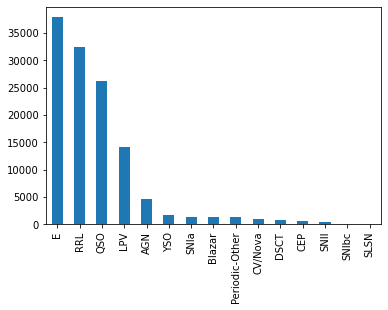

In [15]:
print (df_labels['classALeRCE'].value_counts())
df_labels['classALeRCE'].value_counts().plot(kind='bar')

In [16]:
labels = df_labels['classALeRCE'].unique()
print (labels)

['AGN' 'Blazar' 'CV/Nova' 'CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'QSO'
 'RRL' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'YSO']


Select a test set of approximately 20% of the data.

In [17]:
df_train, df_test = train_test_split(df_labels, test_size=0.2, random_state = 53)

E                 7562
RRL               6550
QSO               5191
LPV               2758
AGN                969
YSO                340
SNIa               269
Blazar             265
Periodic-Other     259
CV/Nova            173
DSCT               148
CEP                123
SNII                70
SNIbc               18
SLSN                 5
Name: classALeRCE, dtype: int64


<AxesSubplot:title={'center':'Trest subset set'}>

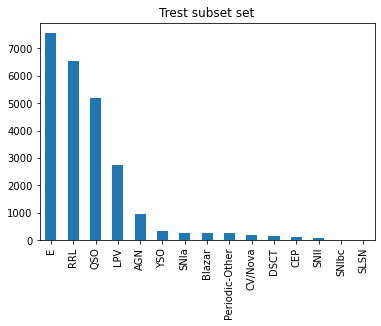

In [18]:
print (df_test['classALeRCE'].value_counts())
df_test['classALeRCE'].value_counts().plot(kind='bar', title = "Trest subset set")

E                 30339
RRL               25932
QSO               20977
LPV               11318
AGN                3698
YSO                1400
SNIa               1003
Blazar             1002
Periodic-Other      997
CV/Nova             698
DSCT                584
CEP                 495
SNII                258
SNIbc                76
SLSN                 19
Name: classALeRCE, dtype: int64


<AxesSubplot:title={'center':'Training set'}>

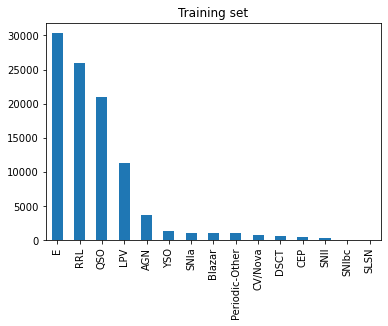

In [19]:
print (df_train['classALeRCE'].value_counts())
df_train['classALeRCE'].value_counts().plot(kind='bar', title = "Training set")

Select no more than 1000 per class.

In [20]:
N_train = 100
df_train_ss = pd.DataFrame (columns = df_labels.columns)
for l in labels:
    df_lab = df_train[df_train['classALeRCE'] == l]
    if df_lab.shape[0] <= N_train:
        df_train_ss = pd.concat ((df_train_ss, df_lab))
    else:
        df_train_ss = pd.concat ((df_train_ss, df_lab.sample(N_train)))


AGN               100
Blazar            100
CV/Nova           100
CEP               100
DSCT              100
E                 100
LPV               100
Periodic-Other    100
QSO               100
RRL               100
SNII              100
SNIa              100
YSO               100
SNIbc              76
SLSN               19
Name: classALeRCE, dtype: int64


<AxesSubplot:title={'center':'Training subset set'}>

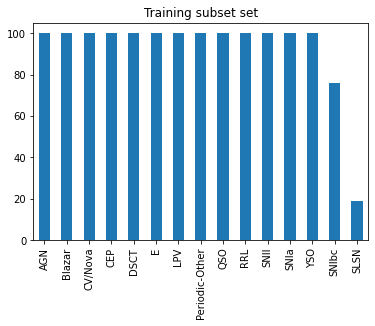

In [21]:
print (df_train_ss['classALeRCE'].value_counts())
df_train_ss['classALeRCE'].value_counts().plot(kind='bar', title = "Training subset set")

Get the features from the ADB.

In [22]:
base_query = """SELECT oid, CONCAT(name, fid) AS feature, value
FROM feature  
WHERE oid IN (%s)"""

In [23]:
#batch = pd.concat((df_train_ss["oid"], df_test["oid"])).values
batch = df_train_ss["oid"].values
batch = [f"'{o}'" for o in batch]
batch = ",".join(batch)

In [24]:
query = base_query % batch

In [25]:
%%time
df_features = pd.read_sql(query, conn)

CPU times: user 543 ms, sys: 860 ms, total: 1.4 s
Wall time: 29.7 s


In [26]:
df_features.head()

,oid,feature,value
0,ZTF17aaaacnc,gal_b0,-15.006629
1,ZTF17aaaacnc,gal_l0,196.282024
2,ZTF17aaaacnc,g-r_max12,1.655367
3,ZTF17aaaacnc,g-r_mean12,0.911558
4,ZTF17aaaacnc,g-r_max_corr12,1.099306


In [27]:
df_features = df_features.pivot_table(values='value', index="oid", columns='feature', aggfunc='first')

In [29]:
df_train_ss

,oid,classALeRCE,ra,dec,source,id_source
1949,ZTF18aadhluq,AGN,139.066666,39.449233,MILLIQUAS,SDSS J091615.99+392657.2
1682,ZTF19abcehsl,AGN,347.279036,-10.143638,MILLIQUAS,SDSS J230906.96-100837.3
3878,ZTF18acvjbvq,AGN,215.793037,-9.284330,MILLIQUAS,PGC 992964
627,ZTF19aamgnns,AGN,150.529306,3.057682,Oh2015,5.877260338462721e+17
3131,ZTF18abnyfsx,AGN,337.581850,16.520198,MILLIQUAS,PGC 3096684
...,...,...,...,...,...,...
122261,ZTF17aaawtse,YSO,83.944566,-5.823976,Simbad_variables,V* CF Ori
122553,ZTF17aadkhda,YSO,85.048080,23.863967,Simbad_variables,[GMM2009] GGD 4 12
123265,ZTF18actaawi,YSO,85.641766,-8.166566,Simbad_variables,2MASS J05423402-0809596
122865,ZTF18abapgwu,YSO,277.089355,0.178087,Simbad_variables,2MASS J18282143+0010409


In [31]:
df_train_ss = df_train_ss.merge(df_features, how = "inner", right_index=True, left_on='oid')

In [37]:
ceph = df_train_ss[df_train_ss['classALeRCE'] == "CEP"]
rrl = df_train_ss[df_train_ss['classALeRCE'] == "RRL"]

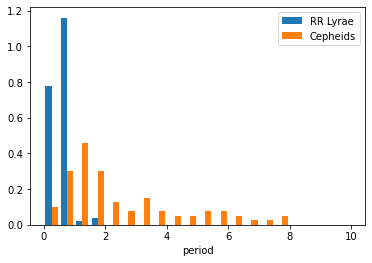

In [54]:
plt.hist ((rrl['Multiband_period12'], ceph['Multiband_period12']), 
          label = ("RR Lyrae", "Cepheids"), bins = 20, range=(0, 10), 
          density = True)
plt.xlabel ("period")
plt.legend()